In [0]:
#@title <b><font color="red">▶</font><font color="black"> run this cell to prepare supplementary materials for the lesson</font></b>

!rm -rf harbour-space-text-mining-course
!git clone https://github.com/horoshenkih/harbour-space-text-mining-course.git
import sys
if 'harbour-space-text-mining-course' not in sys.path:
    sys.path.append('harbour-space-text-mining-course')

# from tmcourse.demo import (
# )
# from tmcourse.quiz import (
# )
from tmcourse.ipyquiz import Quiz, Function
from tmcourse.utils import enable_mathjax_in_cell

from IPython.display import HTML, display

# get_ipython().events.register('pre_run_cell', enable_mathjax_in_cell)
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)


Cloning into 'harbour-space-text-mining-course'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (256/256), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 563 (delta 136), reused 184 (delta 64), pack-reused 307
Receiving objects: 100% (563/563), 89.58 MiB | 18.97 MiB/s, done.
Resolving deltas: 100% (319/319), done.
Checking out files: 100% (76/76), done.


<!--@slideshow slide-->
<h1><center>Recurrent Neural Networks - 2</center></h1>


<!--@slideshow slide-->
# Last time
1. Recurrent functions accept sequences as inputs.
$$
h_t = f(x_t, h_{t-1})
$$
1. Recurrent Neural Networks are recurrent _layers_: they consist of linear transformations followed by activation functions.
$$
h_t = \mathrm{SomeFunction}(W_{xh}x_t + W_{hh}h_{t-1})
$$
1. RNNs are trained with backpropagation on "unrolled" computational graph.
1. Examples of tasks solved by RNNs: classification and language modeling.

<!--@slideshow slide-->
# Plan for today
1. Methods of gradient optimization.
1. When RNN fails: conflicting updates.
1. Long Short-Term Memory (LSTM)

<!--@slideshow slide-->
# Methods of gradient optimization
## Colab demo: gradient methods for neural networks
[link](https://colab.research.google.com/drive/1TEX4GuQLU1oEYes-zhAMvoahRZ1yJHMl?usp=sharing)

<!--@slideshow slide-->
## Colab demo: PyTorch optimizers

In [0]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    # the same as LanguageModelRNN from the previous lecture, but without conditioning
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        # h_t = f(h_{t-1}, x_t)
        hidden = self.relu(self.hh(h) + self.xh(x))
        # o_t = g(h_t)
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        return torch.zeros(1, self.hidden_size)

`process_sequence_rnn()` builds many-to-many computational graph.

![link text](https://raw.githubusercontent.com/horoshenkih/harbour-space-text-mining-course/master/pic/rnn-lm.png)

In [0]:
def process_sequence_rnn(
    rnn,
    input_line_tensor,
    target_line_tensor,
    learning_rate
):
    # the same as process_sequence_language_model from the previous lecture
    # (but witout conditioning)

    # instead of manual parameter update, we will use PyTorch optimizer
    # create the optimizer
    optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
    optimizer.zero_grad()

    loss_function = nn.NLLLoss()
    hidden = rnn.h0()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        # update the loss for each element x_t
        l = loss_function(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # perform gradient step
    optimizer.step()

    return loss.item() / input_line_tensor.size(0)

<!--@slideshow slide-->
# When RNN fails: conflicting updates

In [0]:
#@slideshow slide
def toy_example(char_seq):
    """
    Synthetic dataset.
    Input: sequence of characters `char_seq`.
    Target: "turn on" 1 if "+" is found, wait for "-" to turn off.
    """
    target = []
    turned_on = 0
    for c in char_seq:
        if c == "+":
            turned_on = 1
        elif c == "-":
            turned_on = 0
        target.append(turned_on)
    return target

inp = "aajh-dd+dklddf+dd-jjola"
print("input: ", inp)
print("target:", "".join(map(str, toy_example(inp))))

input:  aajh-dd+dklddf+dd-jjola
target: 00000001111111111000000


<!--@slideshow slide-->
## Colab demo: train RNN on the toy dataset

Generate synthetic sequences with `generate_data()`.

In [0]:
import torch
import random

def get_vocabulary(n_additional_symbols):
    lower = "abcdefghijklmnopqrstuvwxyz"
    return list("+-" + lower[:n_additional_symbols])

def generate_data(n_samples, seed=0, n_additional_symbols=0):
    alphabet = get_vocabulary(n_additional_symbols)
    random.seed(seed)

    char_tensor = torch.zeros(n_samples, 1, len(alphabet))  # one-hotted, 1 batch
    target_tensor = torch.zeros(n_samples, 1)
    index_seq = random.choices(range(len(alphabet)), k=n_samples)
    char_seq = [alphabet[i] for i in index_seq]  # human-readable
    for k, idx in enumerate(index_seq):
        char_tensor[k][0][idx] = 1
    
    # target: turn on if "+", turn off if "-"
    target_seq = toy_example(char_seq)
    for i, target in enumerate(target_seq):
        target_tensor[i][0] = target

    return "".join(char_seq), "".join(map(str, target_seq)), char_tensor, target_tensor.type(torch.LongTensor)

print("0 additional symbols")
chars, target, chars_tensor, target_tensor = generate_data(100)
print(chars)
print(target)
print()

print("10 additional symbols")
chars, target, chars_tensor, target_tensor = generate_data(100, n_additional_symbols=10)
print(chars)
print(target)

0 additional symbols
--++-+-++---+--+----+---+++---+-+--+-+--++-++-+-+--+++--+--------+-+-+++--++-------+-+------+----+-+
0011010110001001000010001110001010010100110110101001110010000000010101110011000000010100000010000101

10 additional symbols
ihdbechbdfiebhfbijhibgigd-dfijdibhe+gchg+diabiaeajhd+bej-egehejffdfcebaaffd-hijiijecgbhiifjedfjjh+fd
0000000000000000000000000000000000011111111111111111111100000000000000000000000000000000000000000111


Training loop for many-to-many RNN.

In [0]:
def train_many_to_many_rnn(
    n_additional_symbols=0,
    hidden_size=16,
    sequence_length=50,
    n_iters=1000,
    learning_rate=0.0005
):
    from tqdm.notebook import tqdm
    import numpy as np
    import matplotlib.pyplot as plt
    print_every = n_iters // 20

    rnn = RNN(n_additional_symbols + 2, hidden_size, 2)
    all_losses = []
    iterations = []
    losses = []

    for i in tqdm(range(1, n_iters + 1)):
        # random sample
        chars, target, input_tensor, target_tensor = generate_data(
            sequence_length,
            seed=i,
            n_additional_symbols=n_additional_symbols
        )
        loss = process_sequence_rnn(
            rnn,
            input_tensor,
            target_tensor,
            learning_rate
        )

        all_losses.append(loss)

        if i % print_every == 0:
            iterations.append(i)
            avg_loss = np.mean(all_losses[-print_every:])
            losses.append(avg_loss)
            print(f"iteration {i}: loss {avg_loss}")

    plt.plot(iterations, losses)
    plt.show()

    return rnn

Auxiliary functions.

In [0]:
def evaluate(rnn, input_tensor):
    # read the sequence and return the final output
    hidden = rnn.h0()

    outputs = torch.zeros(input_tensor.size()[0], 1, 2)
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)
        outputs[i][0] = output

    return outputs

def prediction_chars(prediction_tensor):
    chars = []
    for i in range(prediction_tensor.size()[0]):
        if prediction_tensor[i][0][0] > prediction_tensor[i][0][1]:
            chars.append('0')
        else:
            chars.append('1')
    return chars

def visualize_predictions(rnn, seed, n_additional_symbols, sequence_length=50):
    chars, target, input_tensor, target_tensor = generate_data(
        sequence_length,
        seed=seed,
        n_additional_symbols=n_additional_symbols
    )

    prediction = evaluate(rnn, input_tensor)

    print("input:     ", "".join(chars))
    print("target:    ", "".join(target))
    print("prediction:", "".join(prediction_chars(prediction)))

### Case 1: 2 symbols in the input sequence (no additional symbols)

iteration 75: loss 0.5824393910725912
iteration 150: loss 0.4482204605102538
iteration 225: loss 0.3374387789408365
iteration 300: loss 0.24238757909138997
iteration 375: loss 0.16331397171020506
iteration 450: loss 0.10262045358022054
iteration 525: loss 0.0609679770787557
iteration 600: loss 0.03369225133260091
iteration 675: loss 0.01731060457229614
iteration 750: loss 0.008520272262891135
iteration 825: loss 0.003918508321046829
iteration 900: loss 0.001730946577588717
iteration 975: loss 0.0006913258825739224
iteration 1050: loss 0.00025948776379227636
iteration 1125: loss 8.15545218065381e-05
iteration 1200: loss 2.720299752739569e-05
iteration 1275: loss 8.475100897097339e-06
iteration 1350: loss 2.4604639542909955e-06
iteration 1425: loss 7.260301332280507e-07
iteration 1500: loss 1.9003530960617357e-07



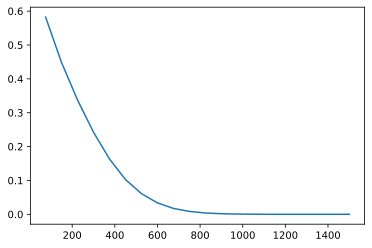

In [0]:
rnn = train_many_to_many_rnn(n_additional_symbols=0, n_iters=1500)

In [0]:
visualize_predictions(rnn, 99999, 0)

input:      ++--+++---+++----+-+--+-+-----+-+--+-++++-+----+++
target:     11001110001110000101001010000010100101111010000111
prediction: 11001110001110000101001010000010100101111010000111


### Case 2: 10 additional symbols
More iterations are needed to converge.

iteration 200: loss 0.6745978315353394
iteration 400: loss 0.6419574869155883
iteration 600: loss 0.5768209342956543
iteration 800: loss 0.4408211380958557
iteration 1000: loss 0.370727063369751
iteration 1200: loss 0.2896961230516434
iteration 1400: loss 0.2862264859676361
iteration 1600: loss 0.22057945513725283
iteration 1800: loss 0.19802337727546693
iteration 2000: loss 0.14137111538648608
iteration 2200: loss 0.10097380085587503
iteration 2400: loss 0.08352887723445893
iteration 2600: loss 0.06659694605693221
iteration 2800: loss 0.036797118598967796
iteration 3000: loss 0.04129782593101263
iteration 3200: loss 0.06225656710714102
iteration 3400: loss 0.0494260509090498
iteration 3600: loss 0.05862560116848908
iteration 3800: loss 0.03250046929905657
iteration 4000: loss 0.04868502158209449



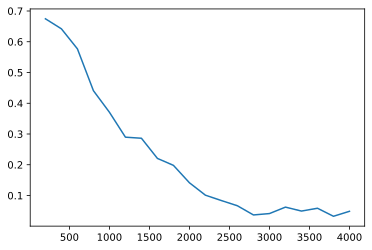

In [0]:
rnn = train_many_to_many_rnn(n_additional_symbols=10, n_iters=4000)

In [0]:
visualize_predictions(rnn, 99999, 10)

input:      -bjgcacjfh+bcehegajbhg-f-fiefjchcge-ic++dh+iehfb+c
target:     00000000001111111111110000000000000000111111111111
prediction: 00000000001111111111110000000000000000111111111111


### Case 3: 26 additional symbols
ote that there are 28 symbols but only 16 components in the hidden state.
This is typical for practical applications: the size of vocabulary is larger than the number of components of the hidden state.

More iterations and lower learning rate.

iteration 500: loss 0.7287484447479249
iteration 1000: loss 0.6851722434997558
iteration 1500: loss 0.645134698486328
iteration 2000: loss 0.6330728789520262
iteration 2500: loss 0.5877209798431398
iteration 3000: loss 0.4814555341720581
iteration 3500: loss 0.29896157202720647
iteration 4000: loss 0.20193253436088562
iteration 4500: loss 0.195059329893589
iteration 5000: loss 0.22272064479112624
iteration 5500: loss 0.3217739353549481
iteration 6000: loss 0.44843314056873324
iteration 6500: loss 0.7242917157825828
iteration 7000: loss 1.2667111489918828
iteration 7500: loss 2.357161524847448
iteration 8000: loss 4.930152095853239
iteration 8500: loss 8.40138252355203
iteration 9000: loss 20.677415961150377
iteration 9500: loss 25.595890172998164
iteration 10000: loss 67.30770151922852



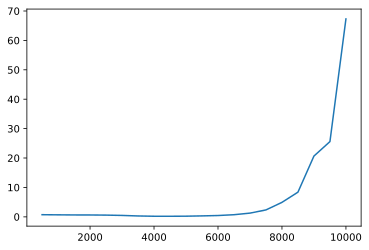

In [0]:
rnn = train_many_to_many_rnn(n_additional_symbols=26, n_iters=10000, learning_rate=0.0002)

In [0]:
visualize_predictions(rnn, 99999, 26)

input:      bgyshdjxov-hioumrczhusaqboxmqzjuismbvj++jt-xnuqg+h
target:     00000000000000000000000000000000000000111100000011
prediction: 00000000000000000000000000000000000000111111111111


<!--@slideshow slide-->
## Problem: conflicting updates

RNN update rule:
$$
h_t = f(W_{xh} x_t + W_{hh} h_{t-1})
$$

**Problem**: $h_t$ is always updated, but _sometimes_ (for some inputs) we want to protect it from updates.


<!--@slideshow slide-->

**Notation**: one-hot encoding of inputs and outputs.

**Input**:
$$x = (0, 1, \dots)^T$$
corresponds to `"+"` character, and
$$x = (1, 0, \dots)^T$$
corresponds to `"-"` character.

**Output**:
$$h = (0, 1)^T$$
corresponds to label 1, and
$$h = (1, 0)^T$$
corresponds to label 0.



<!--@slideshow fragment-->
Only the first two components of $x_t$ are relevant, so we want
$$
W_{xh} = \begin{pmatrix}
1 & 0 & 0 & 0 & \dots\\
0 & 1 & 0 & 0 & \dots\\
\end{pmatrix}
$$

We need the update rule with "protection":
$$
h_t = \begin{cases}
W_{xh} x_t & \textrm{if }W_{xh} x_t \textrm{ is nonzero}\\
h_{t-1}, & \textrm{if }W_{xh} x_t \textrm{ is zero}
\end{cases}
$$

<!--@slideshow slide-->
# Long Short-Term Memory (LSTM)

[Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997).](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf)

<table>
  <tr>
    <td><img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Example-of-LSTM-Architecture.png" height="400"/></td>
    <td><img src="https://static.tvtropes.org/pmwiki/pub/images/6db_3.jpg" height="400"/> </td> 
  </tr>
</table>


<!--@slideshow slide-->
**Idea**: treat the hidden state as "memory" and control its updates depending on the input.

> This is the same what we do in the toy example: update the state only for the particular inputs (`"+"` or `"-"`).

<!--@slideshow fragment-->
**What we have**: layers (matrices + nonlinearities).

**What we want**: memory, conditions (if-else).

<!--@slideshow slide-->
**Memory** will be represented as a vector.
- Each element stores a real number.
- An element can be erased.
- An element can be incremented/decremented.

<!--@slideshow fragment-->
**Conditions** correspond to the _sigmoid function_, which returns values between 0 ("False") and 1 ("True").

<!--@slideshow fragment-->
**Memory updates** (increments and decrements) correspond to _tanh_, which returns values between -1 ("decrement") and 1 ("increment").

<!--@slideshow slide-->
## 1. Cell state and output gate

In general, algorithms don't return the full memory state. So we need to
1. Separate the full memory state from the returning state
1. Decide which parts of the full memory state to return


<!--@slideshow fragment-->
The full memory state is called **cell state** $c_t$.

From the cell state $c_t$, we "return" only some elements.


<!--@slideshow slide-->
We need a function $o_t$ that tells which elements of $c_t$ should be returned:
- This function depends on inputs: $o_t(x_t, h_{t-1})$.
- For each element, it should "return" 0 or 1.
- We will _learn_ this function, so represent it as a layer:
$$
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})
$$

The function $o_t$ that decides which parts of memory to return is called **output gate**.


<!--@slideshow fragment-->
Also, we control the magnitute of the output using tanh:
$$
h_t = o_t \odot \mathrm{tanh}(c_t)
$$

<!--@slideshow slide-->
## 2. Update cell state

From the input $x_t, h_{t-1}$, we decide how to update the cell state $c_t$ (increment or decrement elements).
$$
g_t = \mathrm{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})
$$




<!--@slideshow fragment-->
But we cannot write
$$
c_t = g_t
$$
because we also need to _protect_ some parts of memory.

<!--@slideshow slide-->
## 3. Input gate and forget gate

To _protect_ some parts of memory $c_t$ from overwriting, we need a function $i_t$ that tells which elements should be overwritten.


<!--@slideshow fragment-->
Again, it should return "boolean" (between 0 and 1) values, and we learn it, so it is a layer:
$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})
$$

This function is called **input gate**.

<!--@slideshow slide-->
Similarly, we need to erase (forget) some parts of memory.




<!--@slideshow fragment-->
We need a function $f_t$  (**forget gate**) that "zeroes out" some elements of $c_t$ depending on input.
$$
f_t = \sigma(W_{if}x_t + b_{if} + W_{hf} h_{t-1} + b_{hf})
$$

<!--@slideshow slide-->
The final update of the cell state is
$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t
$$

<!--@slideshow slide-->
Putting it all together, we obtain _LSTM equations_:

$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})
$$
$$
f_t = \sigma(W_{if}x_t + b_{if} + W_{hf} h_{t-1} + b_{hf})
$$
$$
g_t = \mathrm{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})
$$
$$
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho})
$$
$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t
$$
$$
h_t = o_t \odot \mathrm{tanh}(c_t)
$$

<!--@slideshow slide-->
## Colab demo: LSTM implementation in PyTorch

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        # input gate
        self.ii = nn.Linear(input_size, hidden_size)
        self.hi = nn.Linear(hidden_size, hidden_size)

        # forget gate
        self.if_ = nn.Linear(input_size, hidden_size)
        self.hf = nn.Linear(hidden_size, hidden_size)

        # cell
        self.ig = nn.Linear(input_size, hidden_size)
        self.hg = nn.Linear(hidden_size, hidden_size)

        # output gate
        self.io = nn.Linear(input_size, hidden_size)
        self.ho = nn.Linear(hidden_size, hidden_size)

        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

        # transformation of LSTM output to log-probabilities
        self.oo = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, state):
        h, c = state  # state is a pair of hidden state and cell state

        # input gate
        i = self.sigmoid(self.ii(x) + self.hi(h))
        # forget gate
        f = self.sigmoid(self.if_(x) + self.hf(h))
        # cell
        g = self.tanh(self.ig(x) + self.hg(h))
        # output gate
        o = self.sigmoid(self.io(x) + self.ho(h))

        # update cell state
        cell = f * c + i * g
        # update hidden state
        hidden = o * self.tanh(cell)

        # output
        output = self.softmax(self.oo(hidden))

        return output, (hidden, cell)

    def h0c0(self):
        return torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size)

In [0]:
def process_sequence_lstm(
    lstm,
    input_line_tensor,
    target_line_tensor,
    learning_rate
):
    loss_function = nn.NLLLoss()
    state = lstm.h0c0()
    lstm.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, state = lstm(input_line_tensor[i], state)
        # update the loss for each element x_t
        l = loss_function(output, target_line_tensor[i])
        loss += l

    loss.backward()

    # instead of manual parameter update, we use PyTorch optimizer
    # create the optimizer
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
    # perform gradient step
    optimizer.step()

    return loss.item() / input_line_tensor.size(0)

In [0]:
def train_many_to_many_lstm(
    n_additional_symbols=0,
    hidden_size=16,
    sequence_length=50,
    n_iters=1000,
    learning_rate=0.0005
):
    from tqdm.notebook import tqdm
    import numpy as np
    import matplotlib.pyplot as plt
    print_every = n_iters // 20

    lstm = LSTM(n_additional_symbols + 2, hidden_size, 2)
    all_losses = []
    iterations = []
    losses = []

    for i in tqdm(range(1, n_iters + 1)):
        # random sample
        chars, target, input_tensor, target_tensor = generate_data(
            sequence_length,
            seed=i,
            n_additional_symbols=n_additional_symbols
        )
        loss = process_sequence_lstm(
            lstm,
            input_tensor,
            target_tensor,
            learning_rate
        )

        all_losses.append(loss)

        if i % print_every == 0:
            iterations.append(i)
            avg_loss = np.mean(all_losses[-print_every:])
            losses.append(avg_loss)
            print(f"iteration {i}: loss {avg_loss}")

    plt.plot(iterations, losses)
    plt.show()

    return lstm

### Case 1: 2 symbols in the input sequence (no additional symbols)

iteration 75: loss 0.673784790547689
iteration 150: loss 0.601587994893392
iteration 225: loss 0.5204579518636069
iteration 300: loss 0.4237422973632813
iteration 375: loss 0.3240033788045247
iteration 450: loss 0.23352190424601232
iteration 525: loss 0.15813283678690593
iteration 600: loss 0.10165374081929525
iteration 675: loss 0.06219682159423828
iteration 750: loss 0.03679808924992879
iteration 825: loss 0.021009723790486656
iteration 900: loss 0.011602844111124673
iteration 975: loss 0.006125418277581534
iteration 1050: loss 0.003093596049149831
iteration 1125: loss 0.0015067707707484563
iteration 1200: loss 0.0007321239223082861
iteration 1275: loss 0.00034567927842338883
iteration 1350: loss 0.00016063024625182154
iteration 1425: loss 7.358108212550481e-05
iteration 1500: loss 3.318530417357882e-05



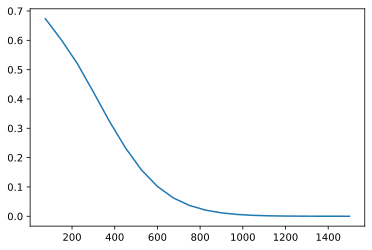

LSTM(
  (ii): Linear(in_features=2, out_features=16, bias=True)
  (hi): Linear(in_features=16, out_features=16, bias=True)
  (if_): Linear(in_features=2, out_features=16, bias=True)
  (hf): Linear(in_features=16, out_features=16, bias=True)
  (ig): Linear(in_features=2, out_features=16, bias=True)
  (hg): Linear(in_features=16, out_features=16, bias=True)
  (io): Linear(in_features=2, out_features=16, bias=True)
  (ho): Linear(in_features=16, out_features=16, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (oo): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

In [0]:
train_many_to_many_lstm(n_additional_symbols=0, n_iters=1500)

### Case 2: 10 additional symbols

iteration 200: loss 0.6951234054565429
iteration 400: loss 0.661283207321167
iteration 600: loss 0.6064778661727905
iteration 800: loss 0.5085322045326233
iteration 1000: loss 0.4371603719711304
iteration 1200: loss 0.35711987166404724
iteration 1400: loss 0.3330982704162598
iteration 1600: loss 0.27774640789031985
iteration 1800: loss 0.24118845374584197
iteration 2000: loss 0.1928666771650314
iteration 2200: loss 0.14620909423828127
iteration 2400: loss 0.10937218556404116
iteration 2600: loss 0.09620821041166781
iteration 2800: loss 0.0672700709849596
iteration 3000: loss 0.03538217113316059
iteration 3200: loss 0.03383302694112063
iteration 3400: loss 0.014020341373607517
iteration 3600: loss 0.016064457090571523
iteration 3800: loss 0.013213039172952997
iteration 4000: loss 0.0007384661371761469



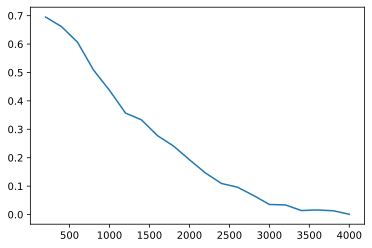

LSTM(
  (ii): Linear(in_features=12, out_features=16, bias=True)
  (hi): Linear(in_features=16, out_features=16, bias=True)
  (if_): Linear(in_features=12, out_features=16, bias=True)
  (hf): Linear(in_features=16, out_features=16, bias=True)
  (ig): Linear(in_features=12, out_features=16, bias=True)
  (hg): Linear(in_features=16, out_features=16, bias=True)
  (io): Linear(in_features=12, out_features=16, bias=True)
  (ho): Linear(in_features=16, out_features=16, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (oo): Linear(in_features=16, out_features=2, bias=True)
  (softmax): LogSoftmax()
)

In [0]:
train_many_to_many_lstm(n_additional_symbols=10, n_iters=4000)

### Case 3: 26 additional symbols


iteration 350: loss 0.6869342203412736
iteration 700: loss 0.6467090443202428
iteration 1050: loss 0.5678114990506854
iteration 1400: loss 0.5116937476975577
iteration 1750: loss 0.44976707893099105
iteration 2100: loss 0.3472116785117558
iteration 2450: loss 0.24888839748246333
iteration 2800: loss 0.1600697932788304
iteration 3150: loss 0.11215235560280937
iteration 3500: loss 0.11374017584238733
iteration 3850: loss 0.14985287925941604
iteration 4200: loss 0.19625219569099803
iteration 4550: loss 0.3114320058917361
iteration 4900: loss 0.29574356720056055
iteration 5250: loss 0.1467482619980352
iteration 5600: loss 0.223645265377413
iteration 5950: loss 0.08843853351095961
iteration 6300: loss 0.011192444947974119
iteration 6650: loss 0.002188556891786362
iteration 7000: loss 9.420798682364356e-09



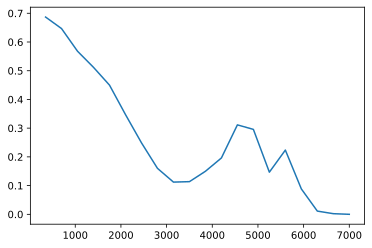

In [0]:
lstm = train_many_to_many_lstm(n_additional_symbols=26, n_iters=7000)

<!--@slideshow slide-->
## Colab demo: `nn.LSTM`

In [0]:
import torch
import torch.nn as nn

class ClassificationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden sise for initialization of h_0, c_0
        self.hidden_size = hidden_size

    def forward(self, x):
        # Set initial states
        h0 = torch.zeros(1, 1, self.hidden_size)
        c0 = torch.zeros(1, 1, self.hidden_size)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (seq_len, batch, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.out(out[-1, :, :])

        return self.softmax(out)

In [0]:
def process_sequence_classification_lstm(lstm, target_tensor, input_tensor, learning_rate):
    loss_function = nn.NLLLoss()
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    output = lstm(input_tensor)
    loss = loss_function(output, target_tensor)

    # backprop + update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

Get the data

In [0]:
#@title run this cell to copy-paste the code from the previous lecture: get the data, define ClassificationRNN

from collections import defaultdict
category_to_names = defaultdict(list)
with open("harbour-space-text-mining-course/datasets/pytorch_tutorial/names_by_language.txt") as f:
    for line in f:
        name, category = line.strip().split("\t")
        category_to_names[category].append(name)

# count total number of letters
all_letters = set()
all_categories = set()

for category, names in category_to_names.items():
    all_categories.add(category)
    for name in names:
        all_letters.update(list(name))
all_letters = list(sorted(all_letters))
all_categories = list(sorted(all_categories))

def name_to_tensor(name, all_letters):
    tensor = torch.zeros(len(name), 1, len(all_letters))
    for li, letter in enumerate(name):
        letter_idx = all_letters.index(letter)
        tensor[li][0][letter_idx] = 1  # one-hot encoding
    return tensor

category_to_training_samples = defaultdict(list)
for category, names in category_to_names.items():
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    for name in names:
        name_tensor = name_to_tensor(name, all_letters)
        sample = category_tensor, name_tensor
        category_to_training_samples[category].append(sample)

class ClassificationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        # instead of explicit matrix multiplications, we use Linear layers
        # W_hh: hidden -> hidden
        self.hh = nn.Linear(hidden_size, hidden_size)
        # W_xh: input -> hidden
        self.xh = nn.Linear(input_size, hidden_size)
        # W_hy: hidden -> output
        self.hy = nn.Linear(hidden_size, output_size)

        # nonlinearities we will use:
        # ReLU for h_t = f(h_{t-1}, x_t)
        self.relu = nn.ReLU()
        # LogSoftmax for y_t = g(h_t) (because we are doing classification)
        self.softmax = nn.LogSoftmax(dim=1)

        # keep hidden sise for initialization of h_0
        self.hidden_size = hidden_size

    def forward(self, x, h):
        # h_t = f(h_{t-1}, x_t)
        hidden = self.relu(self.hh(h) + self.xh(x))
        # y_t = g(h_t)
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        # compute the initial value (all zeros) for the hidden state
        return torch.zeros(1, self.hidden_size)
import torch

def process_sequence_classification(rnn, target_tensor, input_tensor, learning_rate):
    """
    The algorithm:
    - Read the input sequence left-to-right
    - At each step, compute new hidden state and new output
    - Get the last output (probability distribution over classes) and compute loss
    - Backpropagate gradients and update parameters

    input_tensor is a 3-dimensional tensor: sequence length x 1 x vocabulary size
     - the first dimension: each element in this dimension corresponds to x_t
     - the second dimension is a "batch dimension", in our case it always contains 1 element
     - the last dimension contains components of x_t
    """

    # prepare for backprop
    rnn.zero_grad()
    # initialize hidden state
    hidden = rnn.h0()

    # read all elements of the input sequence, update hidden state and output
    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)

    # get the last output, compute the loss function and backpropagate
    loss_function = nn.NLLLoss()
    loss = loss_function(output, target_tensor)
    loss.backward()

    # update parameters
    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item()

Create and train `ClassificationLSTM`. Compare with `ClassificationRNN`.

iteration 1500: LSTM loss 2.8885898360411324, RNN loss 2.893285203933716
iteration 3000: LSTM loss 2.7658053154150646, RNN loss 2.8846190727551777
iteration 4500: LSTM loss 2.621354027231534, RNN loss 2.882097456296285
iteration 6000: LSTM loss 2.6211689501802127, RNN loss 2.874074796994527
iteration 7500: LSTM loss 2.56564092195034, RNN loss 2.867180514971415
iteration 9000: LSTM loss 2.5132711906631786, RNN loss 2.857927730878194
iteration 10500: LSTM loss 2.4743538932104907, RNN loss 2.8513660793304445
iteration 12000: LSTM loss 2.521782964358727, RNN loss 2.8432996147473655
iteration 13500: LSTM loss 2.4292946754433213, RNN loss 2.8324232169787087
iteration 15000: LSTM loss 2.3945914443805814, RNN loss 2.821799316565196
iteration 16500: LSTM loss 2.3213728063795718, RNN loss 2.81094167470932
iteration 18000: LSTM loss 2.2934731169665854, RNN loss 2.798874200344086
iteration 19500: LSTM loss 2.2803049034282257, RNN loss 2.7909389786720276
iteration 21000: LSTM loss 2.138007599181806

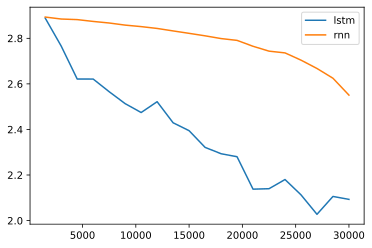

In [0]:
n_hidden = 128
classification_lstm = ClassificationLSTM(len(all_letters), n_hidden, len(all_categories))
classification_rnn = ClassificationRNN(len(all_letters), n_hidden, len(all_categories))

import math
from tqdm.notebook import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
random.seed(0)

n_iters = 30000
print_every = 1500

all_losses = []
iterations = []
losses = []
all_rnn_losses = []
rnn_losses = []

for i in tqdm(range(1, n_iters + 1)):
    random_category = random.choice(all_categories)
    category_tensor, name_tensor = random.choice(category_to_training_samples[random_category])

    loss = process_sequence_classification_lstm(classification_lstm, category_tensor, name_tensor, 0.0005)
    all_losses.append(loss)

    rnn_loss = process_sequence_classification(classification_rnn, category_tensor, name_tensor, 0.001)
    all_rnn_losses.append(rnn_loss)
    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        avg_rnn_loss = np.mean(all_rnn_losses[-print_every:])
        rnn_losses.append(avg_rnn_loss)
        print(f"iteration {i}: LSTM loss {avg_loss}, RNN loss {avg_rnn_loss}")

plt.plot(iterations, losses, label="lstm")
plt.plot(iterations, rnn_losses, label="rnn")
plt.legend()
plt.show()

<!--@slideshow slide-->
# Coding session
## Exercise 1
Refactor your solution from the coding session `6.5_pytorch.ipynb`: in the function `train_clf`, use Adam optimizer.

## Exercise 2
Refactor your solution from the coding session `7_rnn.ipynb` (Exercise 2): use `nn.LSTM` in `ClassificationRNN`.

<!--@slideshow slide-->
# Summary
1. Methods of gradient optimization: "vanilla", momentum, Nesterov momentum, Adagrad, RMSProp, Adam.
1. Conflicting updates in RNN
1. Long Short-Term Memory (LSTM)
  - Treat the hidden state as "memory" and control its updates depending on the input.
  - Cell state and cell update
  - Output gate
  - Input gate
  - Forget gate

<!--@slideshow slide-->
# Recommended resources
- [Deep Learning Book, ch. 10: Sequence Modeling: Recurrentand Recursive Nets](https://www.deeplearningbook.org/contents/rnn.html)
- [Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Sepp Hochreiter and Jürgen Schmidhuber, “Long Short-Term Memory,” Neural Computation 9, no. 8 (1997).](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf)